# Importing Libraries
Importing all the relevant libraries and installing torchinfo to get summary of Models


In [35]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [36]:
!pip install -q torchinfo
from torchinfo import summary

# Walking through Data Directory
Creating a function which walks through the directory.

#### Input:
1. Data directory , type: `str`

#### Returns:
List of all the image folders present in the input directory

1. We get the directory paths, directory names and file names using the `os.walk()` method
2. We calculate the no. of files using `len(filenames)`
3. If the no. of files in a directory is not equal to zero, we append that directory path in the output list

In [37]:
data_dir = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

In [38]:
def walk_through_dir(dir_path):
    image_folders_dir = []
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")
        if len(filenames) != 0:
            image_folders_dir.append(dirpath)
    return image_folders_dir

In [39]:
image_folders_dir = walk_through_dir(data_dir)

There are 90 directories and 0 images in '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals'
There are 0 directories and 60 images in '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle'
There are 0 directories and 60 images in '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/parrot'
There are 0 directories and 60 images in '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/fox'
There are 0 directories and 60 images in '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/wolf'
There are 0 directories and 60 images in '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/hedgehog'
There are 0 directories and 60 images in '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/turtle'
There are 0 directories and 60 images in '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/snake'
There are 0 directories and 60 imag

# Visualizing Random Images
In this section we visualize random images using the following techniques:
1. Using Pillow Library
2. Using Matplotlib

### Using Pillow Library
Here we create a function to display a random image from any random directory
1. We get a random folder directory from the list of directories using `random.choice()`
2. We then get a image name from the random folder directory using `random.choice()` and `os.listdir()`
3. We get the random image path by joining the random folder directory and image name using the method `os.path.join()`
4. We get the image class by spliting the image path using `rand_image_path.split('\')` and then taking the second last element using index = -2
5. Finally we create a `Image.Image` object using `Image.open()`


In [40]:
def random_image_display(seed=42):
    """
    Args:
        seed: an integer to set seed
    
    Returns: 
        a tuple of (image, image class)
    """
    random.seed(seed)
    rand_img_folder = random.choice(image_folders_dir)
    rand_image_path = os.path.join(rand_img_folder, random.choice(os.listdir(rand_img_folder)))
    print(f"Image Path is {rand_image_path}")
    image_class = rand_image_path.split('/')[-2]
    print(f"Image Class is {image_class}")
    img = Image.open(rand_image_path)
    print(f"Image Height: {img.height} || Image Width: {img.width}")
    return img, image_class

Image Path is /kaggle/input/animal-image-dataset-90-different-animals/animals/animals/leopard/20a83ea83f.jpg
Image Class is leopard
Image Height: 174 || Image Width: 290


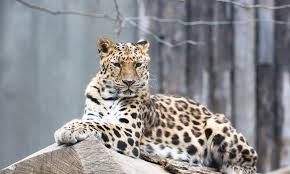

In [41]:
img, image_class = random_image_display()
img

### Using Matplotlib
We create a numpy array of using the random image created using the `random_image_display` function.

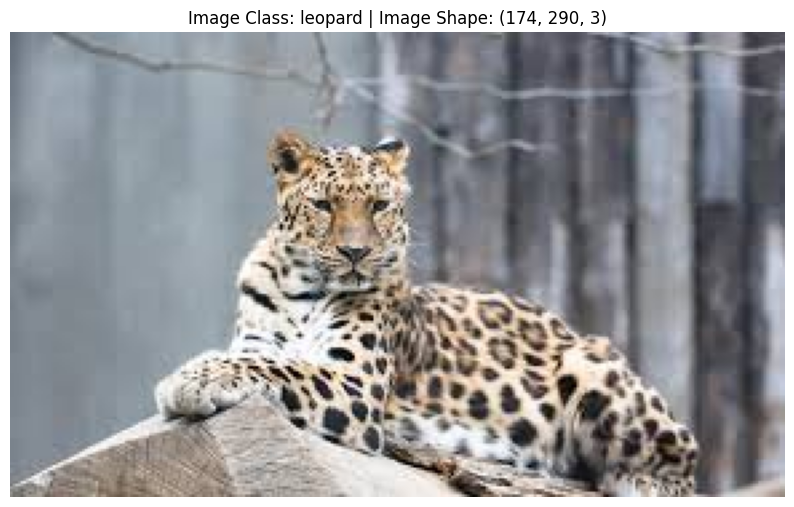

In [42]:
img_as_arr = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_arr)
plt.title(f"Image Class: {image_class} | Image Shape: {img_as_arr.shape}")
plt.axis(False);

# Setting up device agnostic code
We are setting up the device agnostic code, which will allow us to use the GPU if they are available

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

We are using a terminal command `!nvidia-smi` to display the GPU specifications.

In [44]:
!nvidia-smi

Thu Mar  7 07:13:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0              34W / 250W |   1214MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Setting up helper functions
In this Section which create some helper functions which will help us in our tasks.


### Fuction for creating Dataloaders
In this sub-section we define a function to create data loaders.

#### Inputs:
1. `dataset`: datset we want to use, type - `torch.utlts.data.Dataset`
2. `n_splits`: The no of splits we want to use for cross-validation
3. `batch_size`: batch size for training

#### Returns:

**A tuple containing (train_dataloaders, test_dataloaders).** Where 

* train_dataloaders: List containing the training data loaders for each split.

* test_dataloaders: List containing the testing data loaders for each split.

Since we'll get dataloaders for each split. The number of elements in the list is equal to `n_splits`.

#### Explaination
* The fuction uses `sklearn.model_selection.KFold` to create fold with the splits = `n_splits`.
* Used a for loop to iterate and we get `train_ids` and `test_ids` for each fold
* The method `torch.utils.data.SubsetRandomSampler` which takes train_ids and test_ids as input and a subsampler that randomly samples the data.
* Used `torch.utils.data.DataLoader` to create dataloaders which takes input the subsampler, batchsize and dataset.



In [45]:
def create_dataloaders(dataset, n_splits=3, batch_size=16):
    train_dataloaders = []
    test_dataloaders = []
    
    kfold = KFold(n_splits=n_splits, shuffle=True)
    
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        train_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler, pin_memory=True, num_workers=os.cpu_count())
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        test_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=test_subsampler, pin_memory=True, num_workers=os.cpu_count())
        train_dataloaders.append(train_dataloader)
        test_dataloaders.append(test_dataloader)
    return train_dataloaders, test_dataloaders

### Fuction for train step
In this sub-section we define a fuction which implements a training step.

#### Inputs:
1. `model`: type - `torch.nn.Module`
2. `dataloader`: The training dataloader, type - `torch.utils.data.DataLoader`
3. `loss_fn`: The loss function for calculating loss, For example: `CrossEntropyLoss`, type - `torch.nn.Module`
4. `optimizer`: The optimizer for training, For example: `torch.optim.Adam`, type - `torch.optim.Optimizer`
5. `device` : Device agnostic code, to allow us to use GPUs.

#### Returns:

**A tuple containing `train_loss, train_acc`**
* `train_loss`: Training Loss
* `train_acc`: Training Accuracy
    
#### Explaination:
* We set the model in training mode by `model.train()`
* We initialize the `train_loss` and `train_acc` variables with 0
* We iterate through the dataloader using the `enumerate` method which returns the batch no.and a tuple containing (images, labels).
* For each batch, we get the `y_pred` for the input X from the model and then we calcutate the training loss
* For backpropogation, we first ensure that the gradients are zero using `optimizer.zero_grad()` to prevent gradients from accumulating over multiple batches. Then we use `loss.backward()` and `optimizer.step()` for one step of backpropogation.
* From the `y_pred` we get the logits but we don't get the predicted class. So to calculate the class, we use `torch.softmax` and `torch.argmax`
* From the predicted class we get the accuracy comparing `y_pred_class == y`


In [46]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    model.train()

    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

        train_acc += (y_pred_class == y).sum().item() / len(y_pred)


    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

### Fuction for test step
In this sub-section we define a fuction which implements a test step.
#### Inputs:
1. `model`: type - `torch.nn.Module`
2. `dataloader`: The testing dataloader, type - `torch.utils.data.DataLoader`
4. `loss_fn`: The loss function for calculating loss, For example: `CrossEntropyLoss`, type - `torch.nn.Module`
5. `device` : Device agnostic code, to allow us to use GPUs.

#### Returns:

**A tuple containing`train_loss, train_acc`**
* `test_loss`: Testing Loss
* `test_acc`: Testing Accuracy
* `labels`: The True labels
* `predictions`: The predicted labels
    
#### Explaination:
* We set the model in evaluation mode by `model.eval()`
* We initialize the `test_loss` and `test_acc` variables with 0
* We use `torch.inference_mode()` to stop tracking the gradients as recommended by Pytorch.
* We iterate through the dataloader using the `enumerate` method which returns the batch no. and a tuple containing (images, labels).
* For each batch, we get the `test_pred_logits` for the input X from the model and then we calcutate the test loss
* From the `test_pred_logits` we get the logits but we don't get the predicted class. So to calculate the class, we use`torch.argmax`
* From the predicted class we get the accuracy comparing `test_pred_labels == y`

In [47]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

    model.eval()

    test_loss, test_acc = 0, 0
    labels, predictions = [], []
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)

            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)

            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))
            
            labels.extend(y.cpu().numpy())
            predictions.extend(test_pred_labels.cpu().numpy())
    test_loss = test_loss / len(dataloader)

    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc, labels, predictions

### Fuction for training
In this sub-section we define a fuction which implements the training.

#### Inputs:
1. `model`: type - `torch.nn.Module`
2. `train_dataloader`: dataloader for training, type - `torch.utils.data.DataLoader`
3. `test_dataloader`: dataloader for testing, type - `torch.utils.data.DataLoader`
4. `optimizer`: optimizer for training, type - `torch.optim.Optimizer`
5. `loss_fn`: loss function for calculating loss, type - `torch.nn.Module`
6. `epochs`: number of epoch to train
7. `device` : Device agnostic code, to allow us to use GPUs.

#### Returns:
**A tuple containing `results, labels, predictions`**
* `results`: A dictionary containing train loss, train accuracy, test loss and test accuracy.
* `labels`: True Labels
* `predictions`: Predicted labels

#### Explaination
* We initialize the results dictionary
* We create for loop to iterate through each epoch. For each epoch, we calculate the losses and accuracy using `train_step` and `test_step`
* We append the losses and accuracy in the results dictionary.

In [48]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)

        test_loss, test_acc, labels, predictions = test_step(model=model,
                                                             dataloader=test_dataloader,
                                                             loss_fn=loss_fn,
                                                             device=device)


        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)        
    return results, labels, predictions

# One Vs Rest Classification

## Creating a Custom Dataset for one vs rest classification
This class creates a Dataset object which takes the following inputs:

1. `data_dir_path`: data directory
2. `one_idx`: index of the one class from the list of class names
3. `transforms`: transforms required for the model

For this dataset, we'll take all the images from one of the folder and make it one of the class. For the rest class we take 10% of the images from each of the remaining folders.

#### Explaination
* we get the list of class_names using `os.listdir()` and we get the `one_class_name` using the `one_idx` and the list.
* We initialize two lists, one for storing image paths and the other for labels.
* We use a for loop to iterate through each folder using the list - `os.listdir(data_dir_path)`.
* For each iteration we calculate the image percentage we need. So if our `class_name == one_class_name`, we use image percentage equal to 1. Whereas for all others, we take image perentage to be 0.1
* In the loop, we get the folder path using `os.path.join()` for each folder, and then we use another for loop to iterate through all the images in the folder.
* Inside the 2nd for loop we get the image path and label and store them them in the lists.
* We define the fuction `load_image()`, which takes index as an input and return an Image object.
* We define the function `__getitem__()`, which takes index as an input and return the transformed image and label


In [49]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 data_dir_path: str,
                 one_idx: int, 
                 transforms=None):
        class_names = os.listdir(data_dir_path)
        one_class_name = class_names[one_idx]
        self.transforms = transforms
        self.images = []
        self.labels = []
        
        for class_name in class_names:
            if class_name == one_class_name:
                img_percent = 1
            else:
                img_percent = 0.1
                
            folder_path = os.path.join(data_dir_path, class_name)
            for i, img_id in enumerate(os.listdir(folder_path)):
                if i >= img_percent*len(os.listdir(folder_path)):
                    break
                img_path = os.path.join(folder_path, img_id)
                self.images.append(os.path.join(folder_path, img_id))
                if class_name == one_class_name:
                    self.labels.append(1)
                else:
                    self.labels.append(0)
    
    def load_image(self, index:int):
        return Image.open(self.images[index])
        
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index:int):
        img = self.load_image(index)
        label = self.labels[index]
        if self.transforms != None:
            return self.transforms(img), torch.tensor(label, dtype=torch.long)
        return img, label

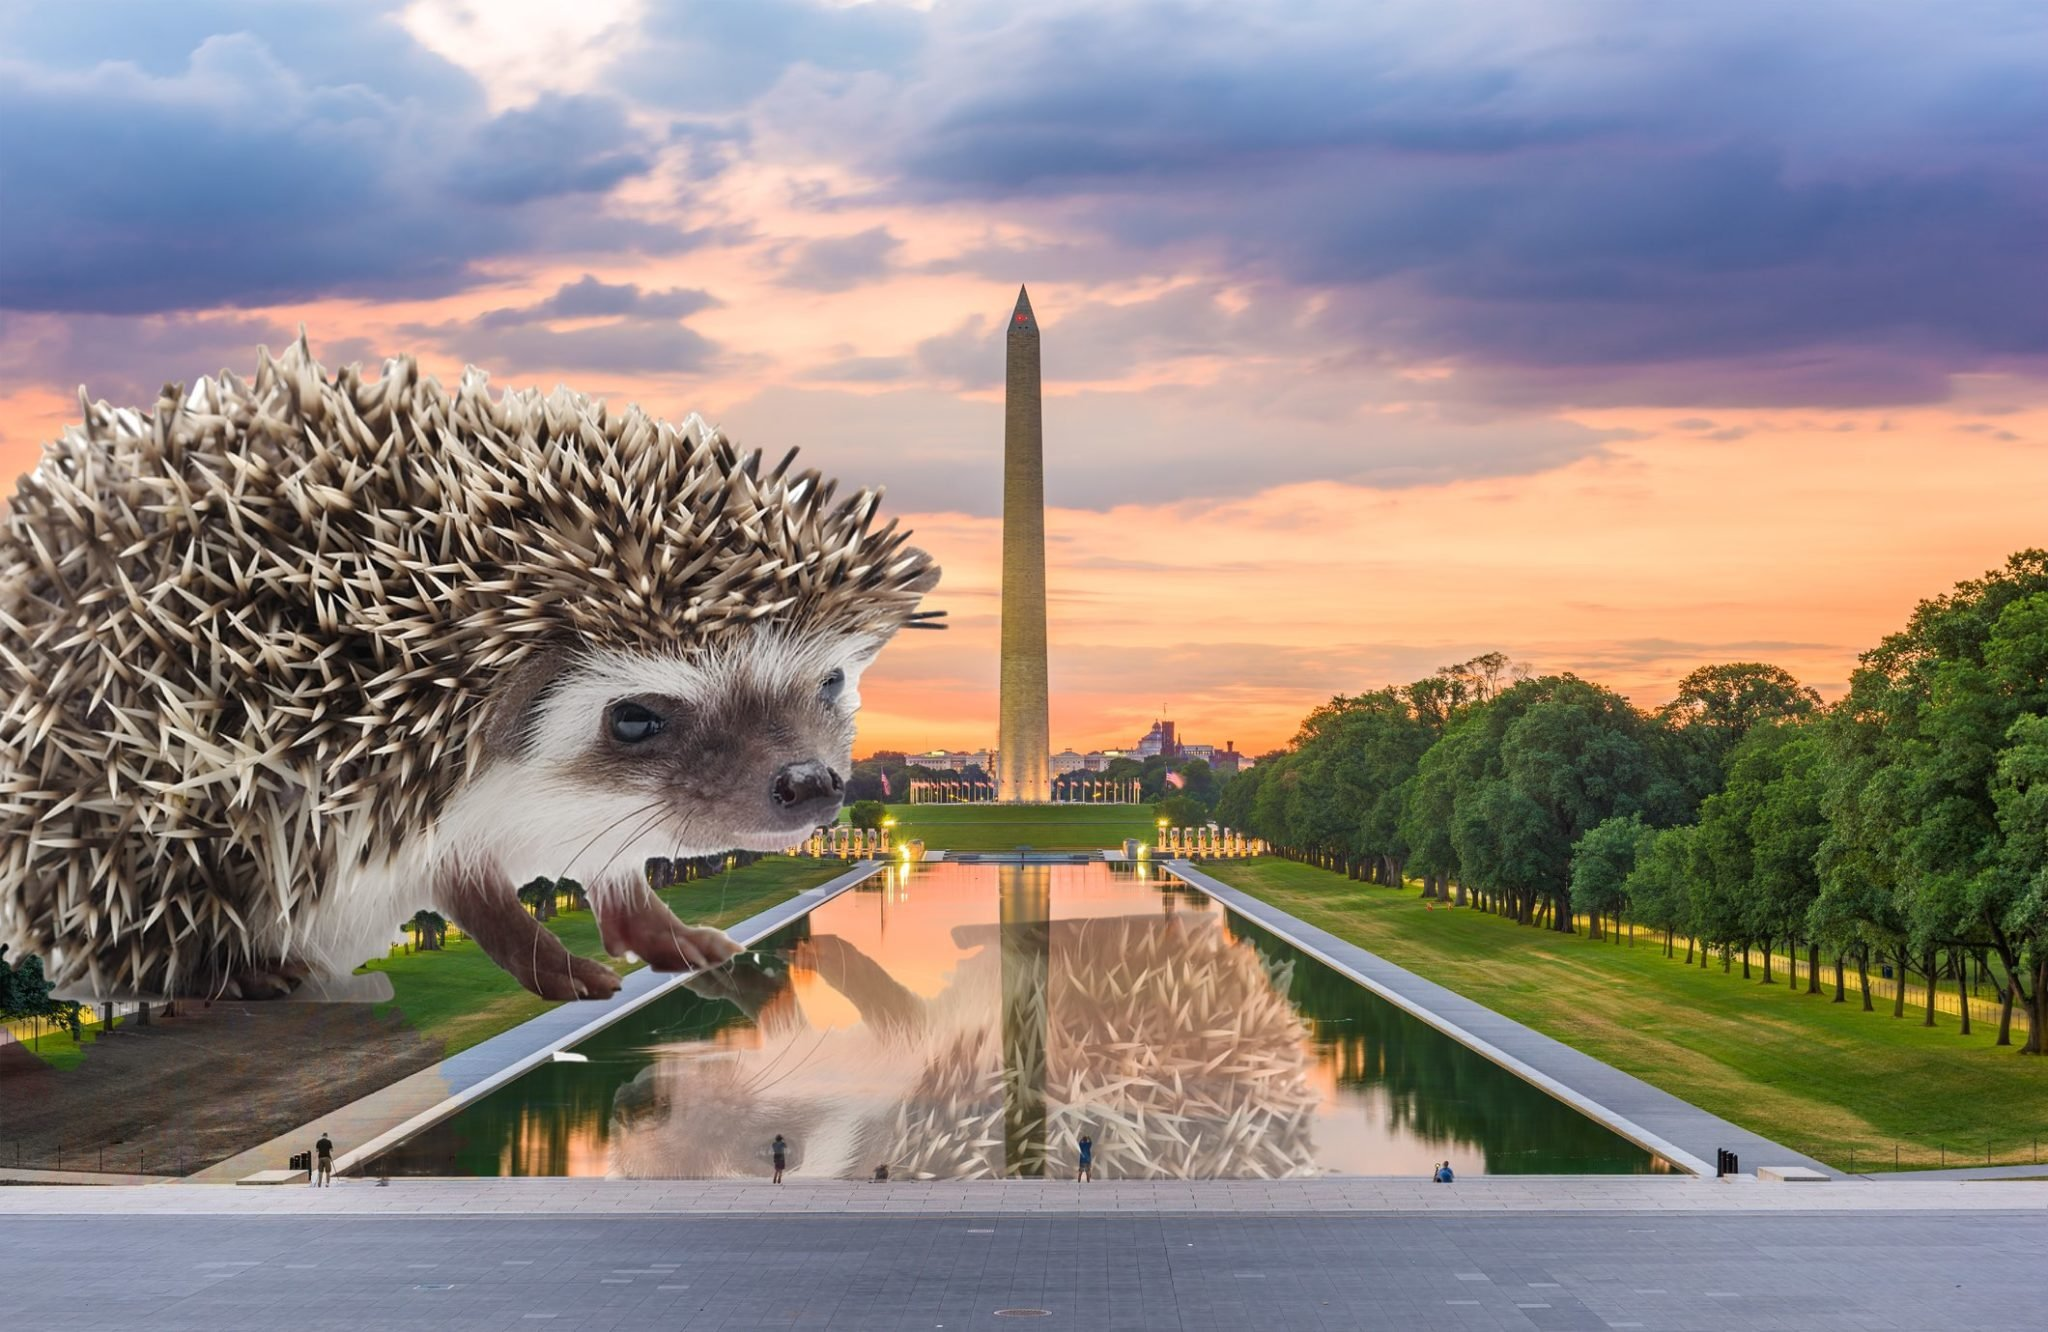

In [50]:
ovrdataset = CustomDataset(data_dir_path=data_dir, one_idx=10)
ovrdataset.load_image(random.choice(range(0, len(ovrdataset))))

## Creating the Classification Function

This function uses all our helper functions and Custom dataset class to perform one vs rest classification.

#### Inputs:
1. `data_dir`: Data directory path
2. `index`: index of the one class
3. `model`: model for training and testing, type - `torch.nn.Module`
4. `model_name`: name of the model, type - `str`
5. `device` : Device agnostic code, to allow us to use GPUs.
6. `transforms`: 
7. `optimizer`: optimizer for training, type - `torch.optim.Optimizer`
8. `loss_function`: loss function for calculating loss, type - `torch.nn.Module`
9. `epochs`: number of epoch to train
10. `n_splits`: The no of splits we want to use for cross-validation
11. `batch_size`: batch size for training

#### Returns:
`one_vs_rest_results`: dictionary that contains all the relevant detail about the model, selected class, and training results.

#### Explaination:

* We initialize the output dictionary - `one_vs_rest_results`
* We create the dataset using `CustomDataset` class
* We get the list of dataloaders using the `create_dataloaders` fuction
* We create a temporary dictionary for storing each fold results.
* We use a for loop to iterate through each fold.
* For each fold we get the dataloader from the dataloader lists. We train the model using the data loaders.
* For each fold we store the result in the `each_fold_results` dictionary
* We print the confusion matrix for each fold
* We save the results in `one_vs_rest_results` dictionary


In [51]:
def one_vs_rest_classification(data_dir, index, model, model_name, device, transforms, optimizer, loss_function, epochs=3, n_splits=3, batch_size=16):
    one_vs_rest_results = {}
    print(f"Classes: {os.listdir(data_dir)[index]} and rest")
    dataset = CustomDataset(data_dir, index, transforms)
    train_dataloaders, test_dataloaders = create_dataloaders(dataset, n_splits, batch_size)
    each_fold_results = {}
    for fold in range(n_splits):
        train_dataloader = train_dataloaders[fold]
        test_dataloader = test_dataloaders[fold]
            
        model.to(device)
            
        results, labels, predictions = train(model,
                                             train_dataloader,
                                             test_dataloader,
                                             optimizer=optimizer,
                                             loss_fn=loss_function,
                                             epochs=epochs,
                                             device=device)
        each_fold_results[fold] = results
        print(f"For Fold - {fold+1}")
        print(confusion_matrix(labels, predictions))
        
    
    one_vs_rest_results["Model"] = model_name
    one_vs_rest_results["Classes"] = f"{os.listdir(data_dir)[index]} and rest"
    one_vs_rest_results["results"] = each_fold_results
    
    return one_vs_rest_results

## Getting a Pre-trained Model
Getting the pretrained vision transformer model and adding a new classifier head.

In [52]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)
pretrained_vit.heads = nn.Linear(in_features=768,
                                 out_features=2).to(device)

### Getting the summary of the model

In [53]:
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

## Creating Transforms, Loss function and Optimizers
Creating transforms for vision transformer, as the transformer takes image size = 224.

In [54]:
ovr_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            ])

In [55]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

## Running the model and saving the loss curves

In [56]:
index = random.choice(range(90))
ovr_results = one_vs_rest_classification(data_dir, index, pretrained_vit,'Pretrained ViT', device, ovr_transforms, optimizer, loss_function, epochs=3, n_splits=3)

Classes: owl and rest
Epoch: 0 | Train loss: 0.1984 | Train acc: 0.9375 | Test loss: 0.1023 | Test acc: 0.9760
Epoch: 1 | Train loss: 0.0641 | Train acc: 0.9900 | Test loss: 0.0942 | Test acc: 0.9808
Epoch: 2 | Train loss: 0.0763 | Train acc: 0.9900 | Test loss: 0.1045 | Test acc: 0.9808
For Fold - 1
[[181   1]
 [  3  13]]
Epoch: 0 | Train loss: 0.0954 | Train acc: 0.9750 | Test loss: 0.0832 | Test acc: 0.9952
Epoch: 1 | Train loss: 0.0753 | Train acc: 0.9850 | Test loss: 0.0854 | Test acc: 0.9904
Epoch: 2 | Train loss: 0.0826 | Train acc: 0.9850 | Test loss: 0.1098 | Test acc: 0.9904
For Fold - 2
[[172   1]
 [  1  24]]
Epoch: 0 | Train loss: 0.0849 | Train acc: 0.9900 | Test loss: 0.0751 | Test acc: 0.9808
Epoch: 1 | Train loss: 0.0790 | Train acc: 0.9900 | Test loss: 0.0951 | Test acc: 0.9712
Epoch: 2 | Train loss: 0.0738 | Train acc: 0.9850 | Test loss: 0.1414 | Test acc: 0.9391
For Fold - 3
[[179   0]
 [ 11   8]]


In [57]:
ovr_results

{'Model': 'Pretrained ViT',
 'Classes': 'owl and rest',
 'results': {0: {'train_loss': [0.19837295830249788,
    0.0641438601911068,
    0.07627295725047588],
   'train_acc': [0.9375, 0.99, 0.99],
   'test_loss': [0.10225605993316723, 0.09420580302293484, 0.104509086563037],
   'test_acc': [0.9759615384615384, 0.9807692307692307, 0.9807692307692307]},
  1: {'train_loss': [0.09540842235088348,
    0.07529457196593285,
    0.08264956764876842],
   'train_acc': [0.975, 0.985, 0.985],
   'test_loss': [0.08321551634715153,
    0.08537379824198209,
    0.10984397622255179],
   'test_acc': [0.9951923076923077, 0.9903846153846154, 0.9903846153846154]},
  2: {'train_loss': [0.08489041671156883,
    0.07899092063307762,
    0.07378983989357948],
   'train_acc': [0.99, 0.99, 0.985],
   'test_loss': [0.07512465319954433, 0.0951233645184682, 0.141424319635217],
   'test_acc': [0.9807692307692307, 0.9711538461538461, 0.9391025641025641]}}}

### Function to plot and save the loss and accuracy curves

In [58]:
def save_loss_curves_ovr(results):
    folder_dir = "/kaggle/working/OnevsRestPrediction"
    directory = os.path.join(folder_dir,f"results_{results['Classes']}")
    os.makedirs(directory, exist_ok=True)
    for fold in results['results']:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)
        axs[0].plot(results['results'][fold]['train_loss'], label='Train Loss', color='red')
        axs[0].plot(results['results'][fold]['test_loss'], label='Test Loss', color='blue')
        axs[0].set_title(f"Loss Curve for Dataset: {results['Classes']} for Fold: {fold+1}")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Loss")
        axs[0].legend()
        axs[1].plot(results['results'][fold]['train_acc'], label='Train Accuracy', color='red')
        axs[1].plot(results['results'][fold]['test_acc'], label='Test Accuracy', color='blue')
        axs[1].set_title(f"Accuracy Curve for Dataset: {results['Classes']} for Fold: {fold+1}")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Loss")
        axs[1].legend()
        plt.savefig(os.path.join(directory, f'{fold+1}.png'))

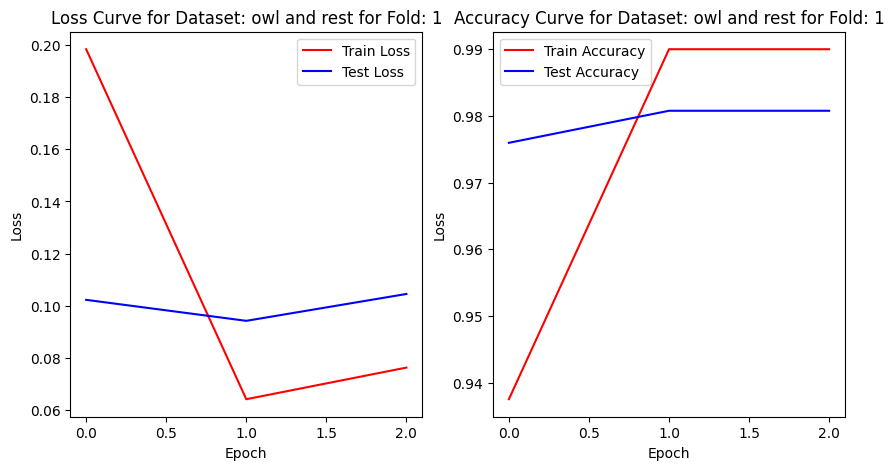

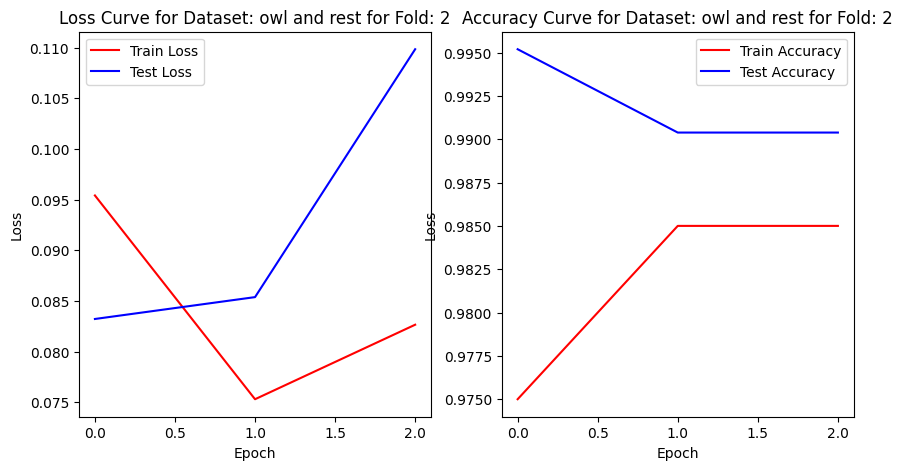

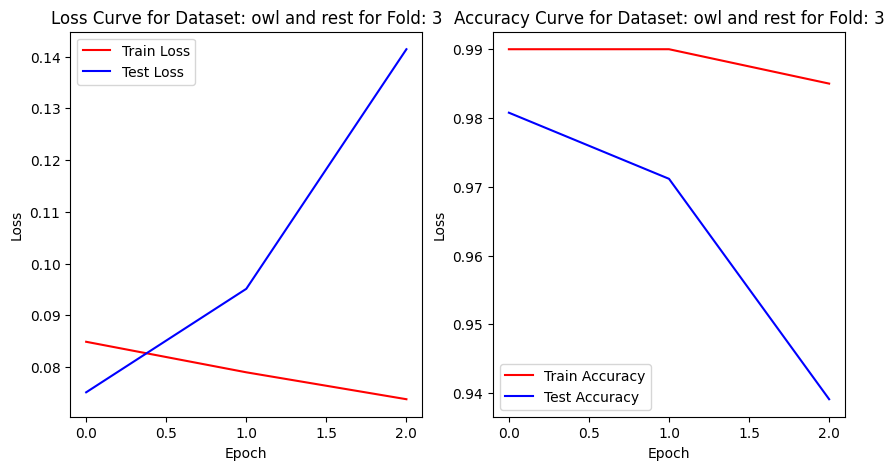

In [59]:
save_loss_curves_ovr(ovr_results)

# 5-class Classification

## Creating a Custom Dataset for 5 class classification
This class creates a Dataset object which takes the following inputs:

1. `data_dir_path`: data directory
2. `list_idxs`: list of indexes of classes
3. `transforms`: transforms required for the model

For this dataset, we'll take all the images from each of the folder given in the input by `list_idxs` and make each of them a seperate class. For the rest class we take 10% of the images from each of the remaining folders.

#### Explaination
* we get the list of class_names using `os.listdir()` and we get the `sep_class_names` using the `list_idxs` and the list.
* We initialize two lists, one for storing image paths and the other for labels.
* We use a for loop to iterate through each folder using the list - `os.listdir(data_dir_path)`.
* For each iteration we calculate the image percentage we need. So if our `class_name in sep_class_names`, we use image percentage equal to 1.  Whereas for all others, we take image perentage to be 0.1
* In the loop, we get the folder path using `os.path.join()` for each folder, and then we use another for loop to iterate through all the images in the folder.
* Inside the 2nd for loop we get the image path and label and store them them in the lists.
* We define the fuction `load_image()`, which takes index as an input and return an Image object.
* We define the function `__getitem__()`, which takes index as an input and return the transformed image and label


In [60]:
class CustomDataset_5class(torch.utils.data.Dataset):
    def __init__(self, 
                 data_dir_path: str,
                 list_idxs, 
                 transforms=None):
        class_names = os.listdir(data_dir_path)
        sep_class_names = [class_names[i] for i in list_idxs]
        self.transforms = transforms
        self.images = []
        self.labels = []
        
        for class_name in class_names:
            if class_name in sep_class_names:
                img_percent = 1
            else:
                img_percent = 0.1
                
            folder_path = os.path.join(data_dir_path, class_name)
            for i, img_id in enumerate(os.listdir(folder_path)):
                if i >= img_percent*len(os.listdir(folder_path)):
                    break
                img_path = os.path.join(folder_path, img_id)
                self.images.append(os.path.join(folder_path, img_id))
                if class_name in sep_class_names:
                    for lb in range(len(list_idxs)):
                        if (class_name == sep_class_names[lb]):
                            self.labels.append(lb+1)
                else:
                    self.labels.append(0)
    
    def load_image(self, index:int):
        return Image.open(self.images[index])
        
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index:int):
        img = self.load_image(index)
        label = self.labels[index]
        if self.transforms:
            return self.transforms(img), torch.tensor(label, dtype=torch.long)
        return img, label

In [61]:
fivec_dataset = CustomDataset_5class(data_dir, [2, 4, 6, 8])

## Creating the Classification funtion

This function uses all our helper functions and Custom dataset class to perform five class classification.

#### Inputs:
1. `data_dir`: Data directory path
2. `list_idxs`: list of all the indexes for the classification
3. `model`: model for training and testing, type - `torch.nn.Module`
4. `model_name`: name of the model, type - `str`
5. `device` : Device agnostic code, to allow us to use GPUs.
6. `transforms`: 
7. `optimizer`: optimizer for training, type - `torch.optim.Optimizer`
8. `loss_function`: loss function for calculating loss, type - `torch.nn.Module`
9. `epochs`: number of epoch to train
10. `n_splits`: The no of splits we want to use for cross-validation
11. `batch_size`: batch size for training

#### Returns:
`five_class_results`: dictionary that contains all the relevant detail about the model, selected class, and training results.

#### Explaination:

* We initialize the output dictionary - `five_class_results`
* We create the dataset using `CustomDataset_5class` class
* We get the list of dataloaders using the `create_dataloaders` fuction
* We create a temporary dictionary for storing each fold results.
* We use a for loop to iterate through each fold.
* For each fold we get the dataloader from the dataloader lists. We train the model using the data loaders.
* For each fold we store the result in the `each_fold_results` dictionary
* We print the confusion matrix for each fold
* We save the results in `five_class_results` dictionary


In [62]:
def five_class_classification(data_dir, list_idxs, model, model_name, device, transforms, optimizer, loss_function, epochs=3, n_splits=3, batch_size=16):
    five_class_results = {}
    print(f"Classes: {[os.listdir(data_dir)[i] for i in list_idxs]} and rest")
    dataset = CustomDataset_5class(data_dir, list_idxs, transforms)
    train_dataloaders, test_dataloaders = create_dataloaders(dataset, n_splits, batch_size)
    each_fold_results = {}
    for fold in range(n_splits):
        print(f'For Fold: {fold+1} \n')
        train_dataloader = train_dataloaders[fold]
        test_dataloader = test_dataloaders[fold]
            
        model.to(device)
            
        results, labels, predictions = train(model,
                                             train_dataloader,
                                             test_dataloader,
                                             optimizer=optimizer,
                                             loss_fn=loss_function,
                                             epochs=epochs,
                                             device=device)
        each_fold_results[fold] = results
        print(f"For Fold - {fold+1}")
        print(confusion_matrix(labels, predictions))
        
    
    five_class_results["Model"] = model_name
    five_class_results["Classes"] = f"{[os.listdir(data_dir)[i] for i in list_idxs].append('rest')}"
    five_class_results["results"] = each_fold_results
    
    return five_class_results

## Getting a Pre-trained Model
Getting the pretrained vision transformer model and adding a new classifier head.

In [63]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)
pretrained_vit.heads = nn.Linear(in_features=768,
                                 out_features=5).to(device)

## Setting up transforms, loss-function and optimizers
Creating transforms for vision transformer, as the transformer takes image size = 224.

In [64]:
fivec_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

In [65]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

In [66]:
list_idxs = [2, 4, 6, 8]
five_class_results = five_class_classification(data_dir, list_idxs, pretrained_vit, "Pretrained ViT", device, fivec_transforms, optimizer, loss_function)

Classes: ['fox', 'hedgehog', 'snake', 'horse'] and rest
For Fold: 1 

Epoch: 0 | Train loss: 0.5307 | Train acc: 0.8516 | Test loss: 0.2658 | Test acc: 0.9557
Epoch: 1 | Train loss: 0.2160 | Train acc: 0.9629 | Test loss: 0.2807 | Test acc: 0.9518
Epoch: 2 | Train loss: 0.2175 | Train acc: 0.9727 | Test loss: 0.2637 | Test acc: 0.9492
For Fold - 1
[[179   1   2   0   1]
 [  0  13   0   0   0]
 [  1   0  16   0   0]
 [  3   0   0  15   0]
 [  5   0   0   0  16]]
For Fold: 2 

Epoch: 0 | Train loss: 0.2395 | Train acc: 0.9551 | Test loss: 0.2628 | Test acc: 0.9596
Epoch: 1 | Train loss: 0.2240 | Train acc: 0.9648 | Test loss: 0.2621 | Test acc: 0.9466
Epoch: 2 | Train loss: 0.2252 | Train acc: 0.9688 | Test loss: 0.2558 | Test acc: 0.9362
For Fold - 2
[[160   0   1   0   2]
 [  2  21   0   0   0]
 [  1   0  20   0   0]
 [  3   0   0  23   0]
 [  7   0   0   0  12]]
For Fold: 3 

Epoch: 0 | Train loss: 0.2435 | Train acc: 0.9492 | Test loss: 0.2211 | Test acc: 0.9727
Epoch: 1 | Train loss

## Function to plot and save the loss and accuracy curves

In [67]:
def save_loss_curves_5class(results, filename):
    folder_dir = "/kaggle/working/fiveclass_Prediction"
    directory = os.path.join(folder_dir,filename)
    os.makedirs(directory, exist_ok=True)
    for fold in results['results']:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=100)
        axs[0].plot(results['results'][fold]['train_loss'], label='Train Loss', color='red')
        axs[0].plot(results['results'][fold]['test_loss'], label='Test Loss', color='blue')
        axs[0].set_title(f"Loss Curve for Dataset: {filename} for Fold: {fold+1}")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Loss")
        axs[0].legend()
        axs[1].plot(results['results'][fold]['train_acc'], label='Train Accuracy', color='red')
        axs[1].plot(results['results'][fold]['test_acc'], label='Test Accuracy', color='blue')
        axs[1].set_title(f"Accuracy Curve for Dataset: {filename} for Fold: {fold+1}")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Loss")
        axs[1].legend()
        plt.savefig(os.path.join(directory, f'{fold+1}.png'))

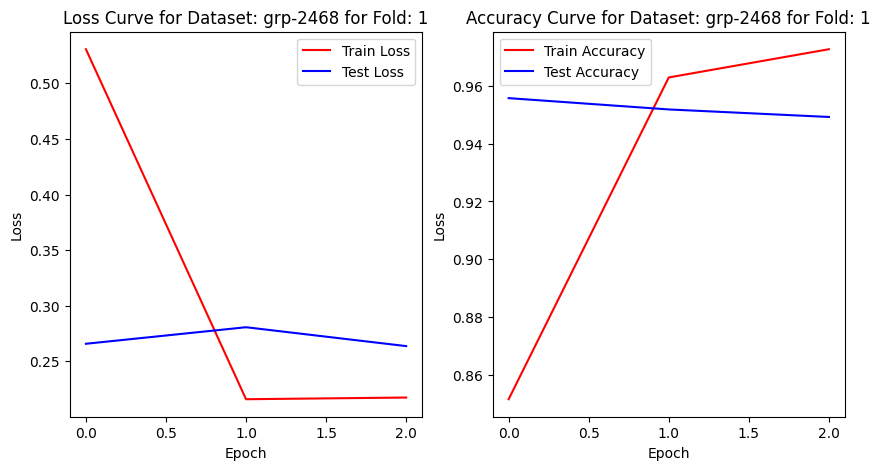

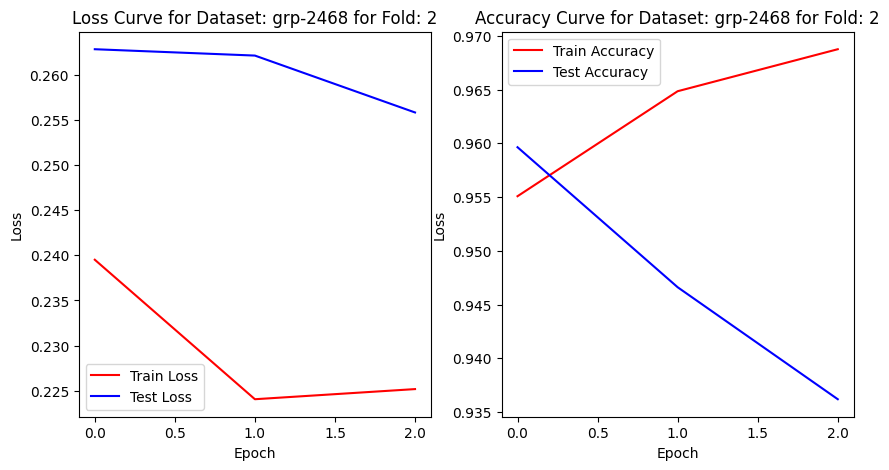

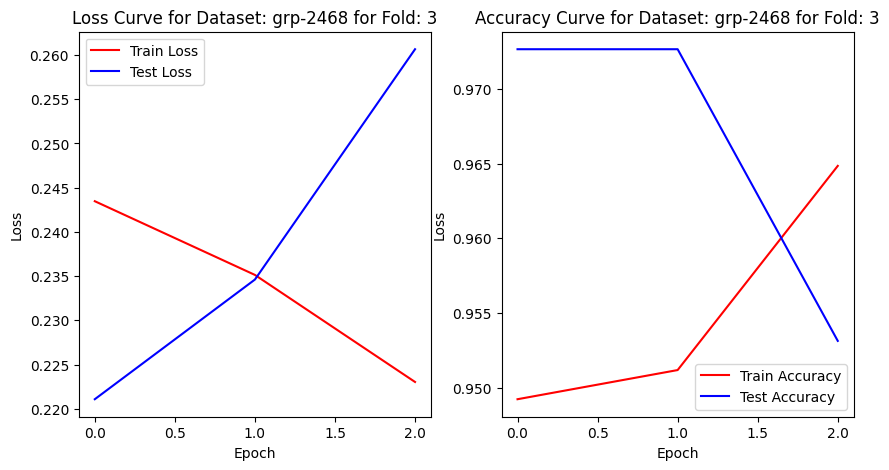

In [68]:
save_loss_curves_5class(five_class_results, "grp-2468")

# Custom Model for Classification

## Creating a Custom Model
Creating a custom model for classification which takes input as number of classes we need to predict.

#### Model details:
* Contains three ConvBlocks and one classifier head created using `nn.Sequential`.
* Each ConvBlock contains convolution layers: `nn.Conv2d()`, batch normalization: `nn.BatchNorm2d()`, activation function: `nn.ReLU()` and pooling layers: `nn.MaxPool2d()`.
* Classifier head - contains a flatten layer which flattens the output of ConvBlocks using `nn.Flatten()`, contains two fully connected layers - `nn.Linear()`


In [69]:
class CustomModel(nn.Module):
    def __init__(self, noc:int):
        super().__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=16,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16,
                      out_channels=32,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=9216,
                      out_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000,
                      out_features=noc)
        )
        
    def forward(self, x):
        x = self.convblock1(x)
#         print(x.shape)
        x = self.convblock2(x)
#         print(x.shape)
        x = self.convblock3(x)
#         print(x.shape)
        x = self.classifier(x)
        return x

This is the final model used for classification. Before this, a lot of experimentation was done with models having less depth and no batch normalization. They resulted in predicting only one class since we have an extremely imbalanced dataset.

## For One Vs Rest Classification

### Creating the Model

In [70]:
ovr_custom_model = CustomModel(noc=2)

In [71]:
ovr_custom_model.to(device)

CustomModel(
  (convblock1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=92

In [72]:
summary(model=ovr_custom_model,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CustomModel (CustomModel)                [32, 3, 224, 224]    [32, 2]              --                   True
├─Sequential (convblock1)                [32, 3, 224, 224]    [32, 16, 74, 74]     --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 16, 224, 224]   448                  True
│    └─BatchNorm2d (1)                   [32, 16, 224, 224]   [32, 16, 224, 224]   32                   True
│    └─ReLU (2)                          [32, 16, 224, 224]   [32, 16, 224, 224]   --                   --
│    └─MaxPool2d (3)                     [32, 16, 224, 224]   [32, 16, 74, 74]     --                   --
├─Sequential (convblock2)                [32, 16, 74, 74]     [32, 32, 25, 25]     --                   True
│    └─Conv2d (0)                        [32, 16, 74, 74]     [32, 32, 75, 75]     2,080                True
│    └─BatchNorm2d

### Setting up transforms, loss_function and optimizer

In [73]:
ovr_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

In [74]:
loss_function = torch.nn.CrossEntropyLoss()
custom_optimizer_ovr = torch.optim.SGD(params=ovr_custom_model.parameters(),
                            lr=0.1)

### Running the Model

In [75]:
index = random.choice(range(90))
ovr_custom_results = one_vs_rest_classification(data_dir, index, ovr_custom_model,'Custom Model', device, ovr_transforms, custom_optimizer_ovr, loss_function, epochs=10, n_splits=3)

Classes: coyote and rest
Epoch: 0 | Train loss: 1.2475 | Train acc: 0.8150 | Test loss: 0.2791 | Test acc: 0.9087
Epoch: 1 | Train loss: 0.3341 | Train acc: 0.8958 | Test loss: 0.3055 | Test acc: 0.9006
Epoch: 2 | Train loss: 0.2873 | Train acc: 0.8975 | Test loss: 0.3114 | Test acc: 0.8926
Epoch: 3 | Train loss: 0.2472 | Train acc: 0.8975 | Test loss: 0.3606 | Test acc: 0.9006
Epoch: 4 | Train loss: 0.2225 | Train acc: 0.8983 | Test loss: 0.2465 | Test acc: 0.9375
Epoch: 5 | Train loss: 0.2384 | Train acc: 0.8950 | Test loss: 0.4484 | Test acc: 0.8846
Epoch: 6 | Train loss: 0.1797 | Train acc: 0.9150 | Test loss: 0.4361 | Test acc: 0.9199
Epoch: 7 | Train loss: 0.1610 | Train acc: 0.9450 | Test loss: 0.2584 | Test acc: 0.9279
Epoch: 8 | Train loss: 0.2258 | Train acc: 0.9350 | Test loss: 0.3327 | Test acc: 0.9327
Epoch: 9 | Train loss: 0.1181 | Train acc: 0.9525 | Test loss: 0.3459 | Test acc: 0.9279
For Fold - 1
[[176   3]
 [ 12   7]]
Epoch: 0 | Train loss: 0.3201 | Train acc: 0.9175

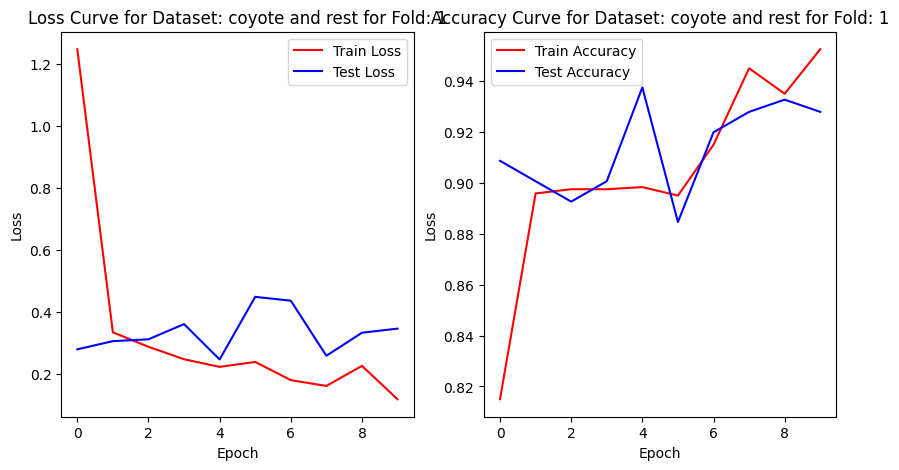

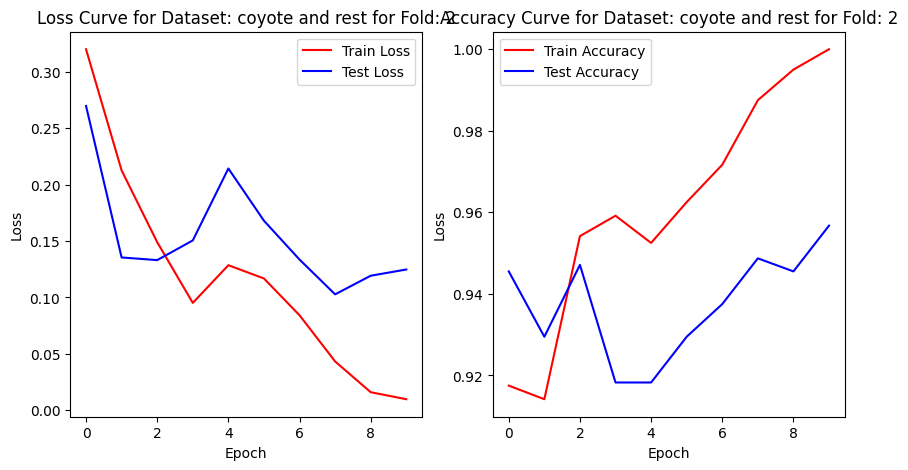

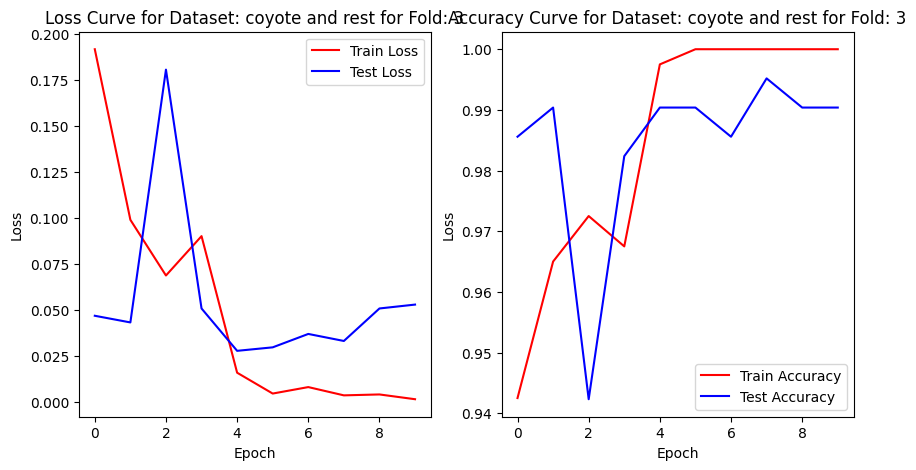

In [76]:
save_loss_curves_ovr(ovr_custom_results)

## For 5-class Classification

### Creating the Model

In [77]:
fivec_custom_model = CustomModel(noc=5)
fivec_custom_model.to(device)

CustomModel(
  (convblock1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=92

In [78]:
summary(model=fivec_custom_model,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CustomModel (CustomModel)                [32, 3, 224, 224]    [32, 5]              --                   True
├─Sequential (convblock1)                [32, 3, 224, 224]    [32, 16, 74, 74]     --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 16, 224, 224]   448                  True
│    └─BatchNorm2d (1)                   [32, 16, 224, 224]   [32, 16, 224, 224]   32                   True
│    └─ReLU (2)                          [32, 16, 224, 224]   [32, 16, 224, 224]   --                   --
│    └─MaxPool2d (3)                     [32, 16, 224, 224]   [32, 16, 74, 74]     --                   --
├─Sequential (convblock2)                [32, 16, 74, 74]     [32, 32, 25, 25]     --                   True
│    └─Conv2d (0)                        [32, 16, 74, 74]     [32, 32, 75, 75]     2,080                True
│    └─BatchNorm2d

### Setting up transforms, loss function and optimizers

In [79]:
fivec_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [80]:
fivec_loss_function = torch.nn.CrossEntropyLoss()
custom_optimizer_fivec = torch.optim.SGD(params=fivec_custom_model.parameters(),
                            lr=0.1)

### Running the model

In [81]:
list_idxs = [2, 4, 6, 8]
five_class_custom_results = five_class_classification(data_dir, list_idxs, fivec_custom_model, "Custom Model", device, fivec_transforms, custom_optimizer_fivec, fivec_loss_function, epochs=10)

Classes: ['fox', 'hedgehog', 'snake', 'horse'] and rest
For Fold: 1 

Epoch: 0 | Train loss: 2.1260 | Train acc: 0.6445 | Test loss: 1.1614 | Test acc: 0.6771
Epoch: 1 | Train loss: 1.1111 | Train acc: 0.6875 | Test loss: 1.9543 | Test acc: 0.6823
Epoch: 2 | Train loss: 1.0609 | Train acc: 0.6914 | Test loss: 1.3600 | Test acc: 0.6771
Epoch: 3 | Train loss: 1.0297 | Train acc: 0.6836 | Test loss: 1.1592 | Test acc: 0.6484
Epoch: 4 | Train loss: 1.0245 | Train acc: 0.6855 | Test loss: 1.3729 | Test acc: 0.6745
Epoch: 5 | Train loss: 0.9470 | Train acc: 0.6875 | Test loss: 1.1103 | Test acc: 0.6745
Epoch: 6 | Train loss: 0.8336 | Train acc: 0.7070 | Test loss: 1.1504 | Test acc: 0.6810
Epoch: 7 | Train loss: 0.8081 | Train acc: 0.6953 | Test loss: 1.1391 | Test acc: 0.6289
Epoch: 8 | Train loss: 0.8412 | Train acc: 0.7051 | Test loss: 1.3024 | Test acc: 0.6185
Epoch: 9 | Train loss: 0.7174 | Train acc: 0.7402 | Test loss: 1.4322 | Test acc: 0.6367
For Fold - 1
[[151   5   0   1  14]
 [ 1

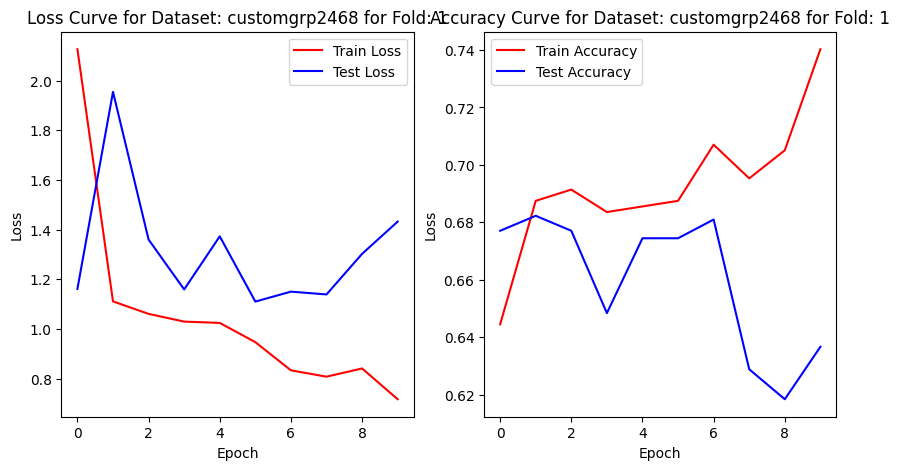

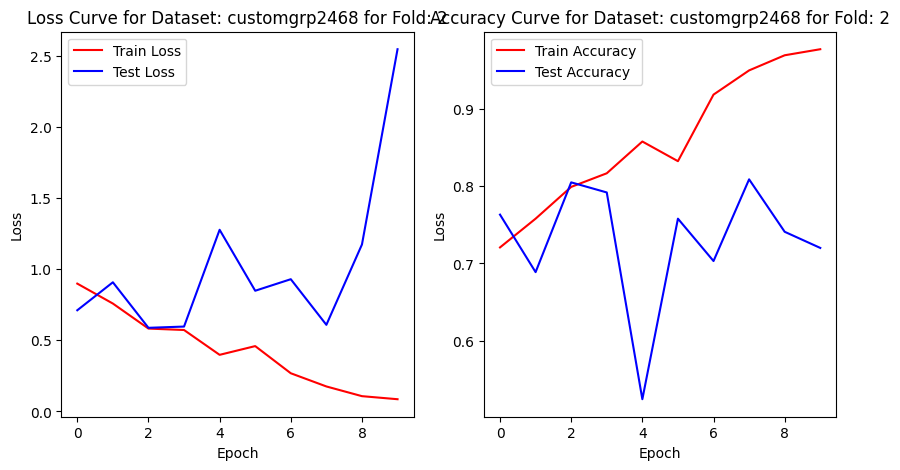

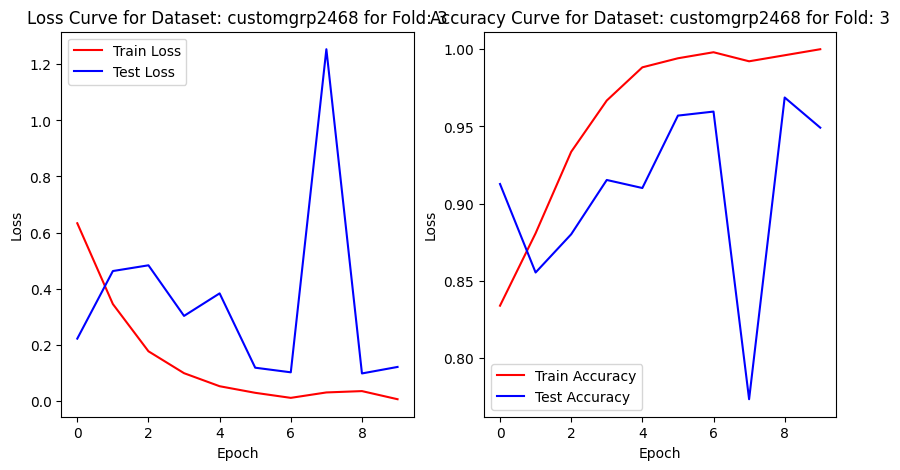

In [82]:
save_loss_curves_5class(five_class_custom_results, 'customgrp2468')

# Visualizing Feature maps of Custom Model
We create a function to visualize the feature maps of the convolution layers.


In [83]:
def visualizing_feature_maps(model, img, transforms, device):
    no_of_layers = 0
    conv_layers = []
    outputs = []
    model_children = list(model.children())
    for child in model_children:
        if type(child) == nn.Sequential:
            for layer in child.children():
                if type(layer) == nn.Conv2d:
                    no_of_layers += 1
                    conv_layers.append(layer)
    
    vis_img = transforms(img).unsqueeze(0).to(device)
    
    outputs.append(conv_layers[0](vis_img))
    for i in range(1, len(conv_layers)):
        outputs.append(conv_layers[i](outputs[-1]))
    
    for num_layer in range(len(outputs)):
        plt.figure(figsize=(50, 10))
        layer_vis = outputs[num_layer].squeeze()
        print("Layer ", num_layer+1)
        for i, f in enumerate(layer_vis):
            plt.subplot(8, 8, i+1)
            plt.imshow(f.detach().cpu().numpy())
            plt.axis("off")
    
        plt.show()
        
    return outputs, conv_layers

* Each feature map tells us that the model is focused on which details.
* In each feature map, if the pixels are bright, our model is focussing on those details. Whereas, If the pixels are dark, our model ignores those details.
* We can see that each feature map focuses on different details

Layer  1


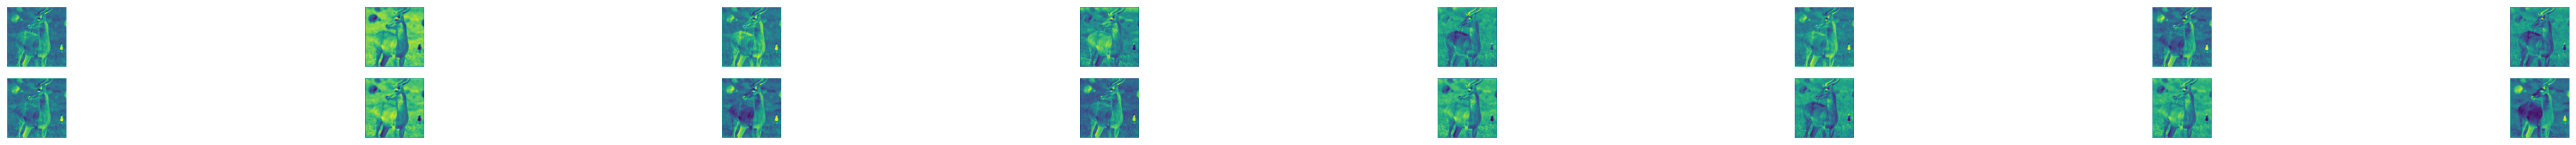

Layer  2


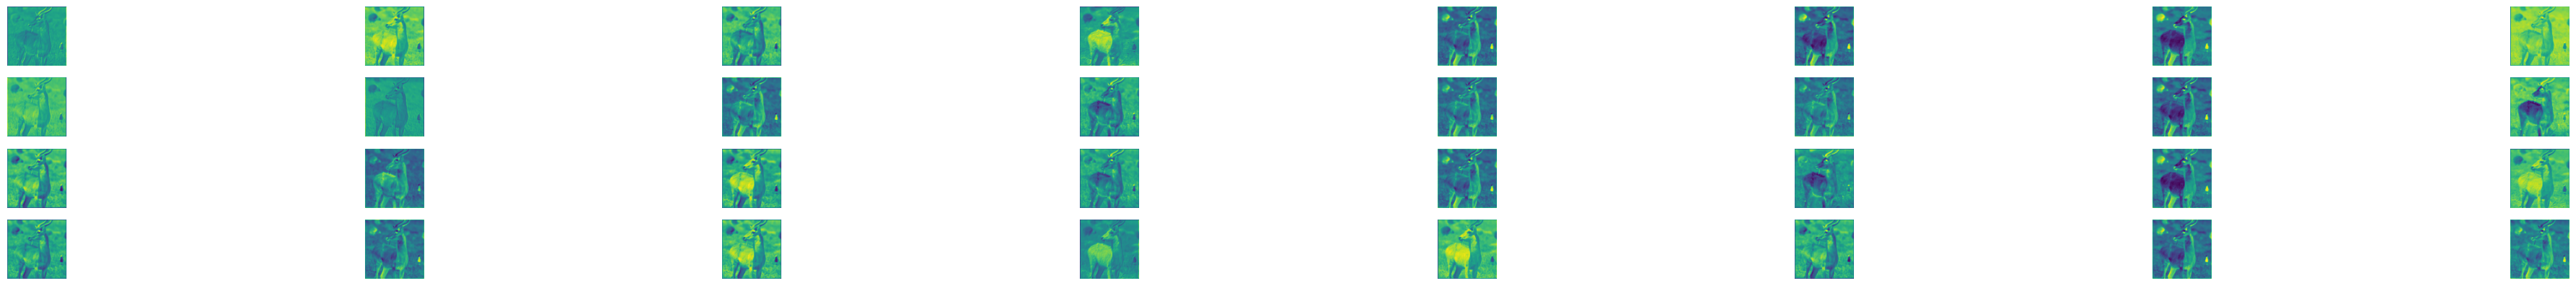

Layer  3


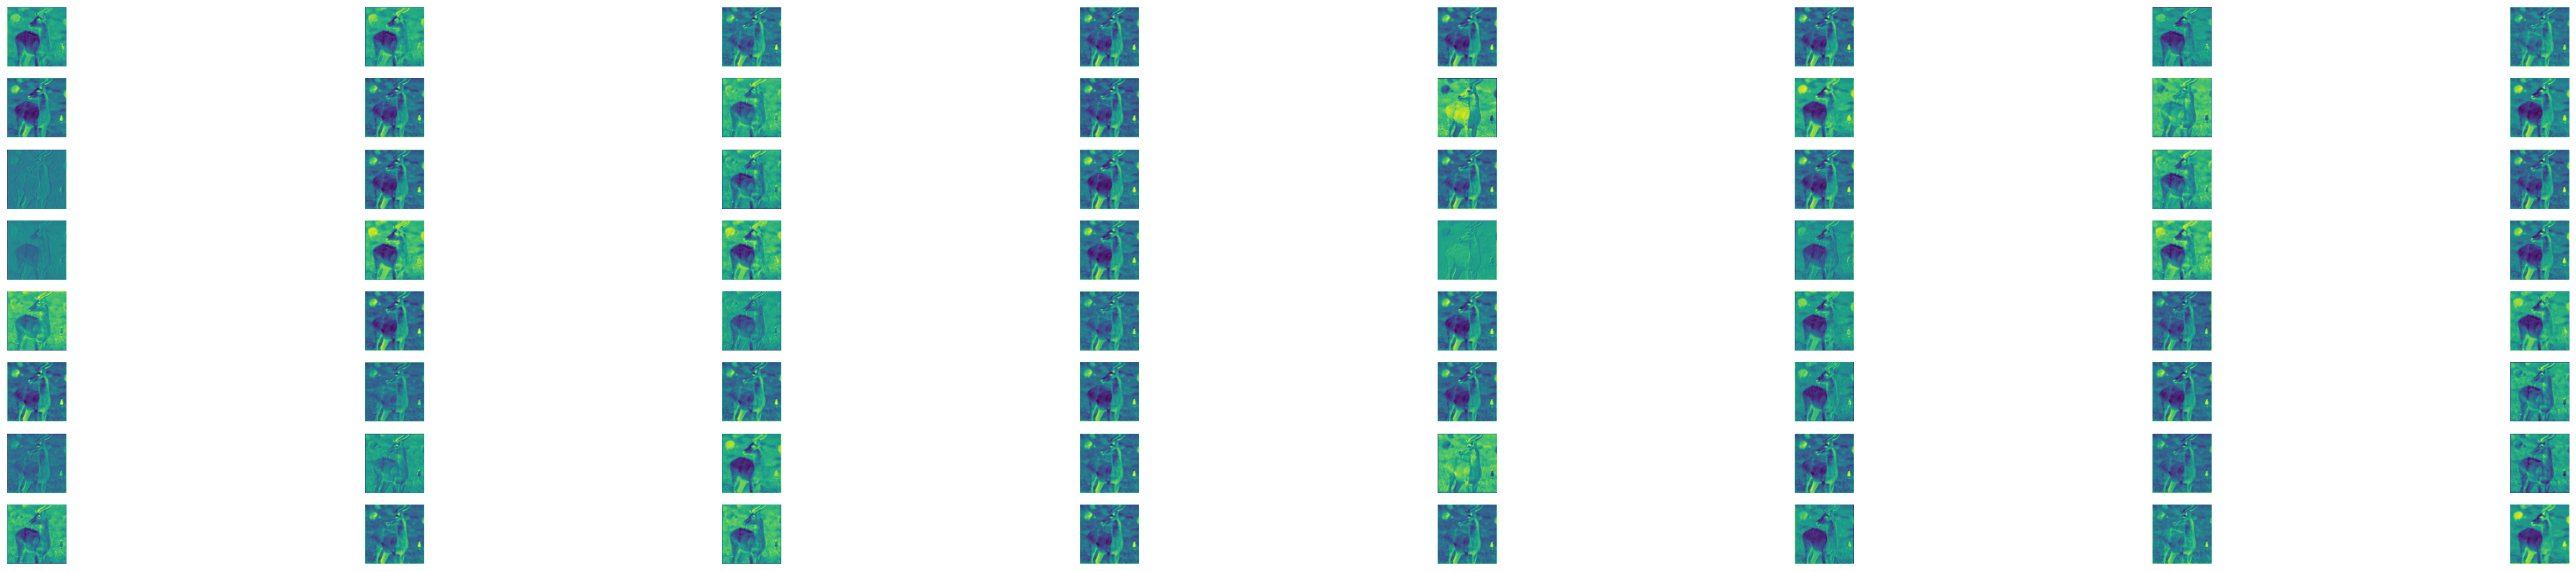

In [84]:
ovr_outputs, ovr_conv_layers = visualizing_feature_maps(ovr_custom_model, ovrdataset.load_image(56), ovr_transforms, device)

Layer  1


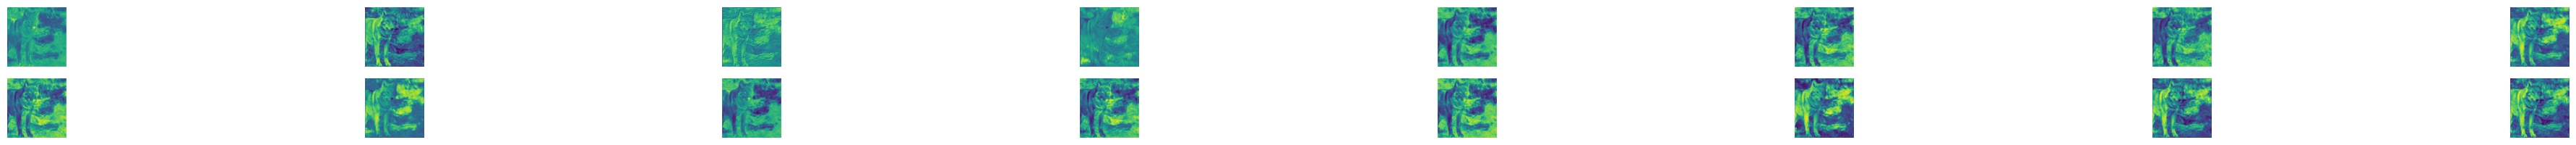

Layer  2


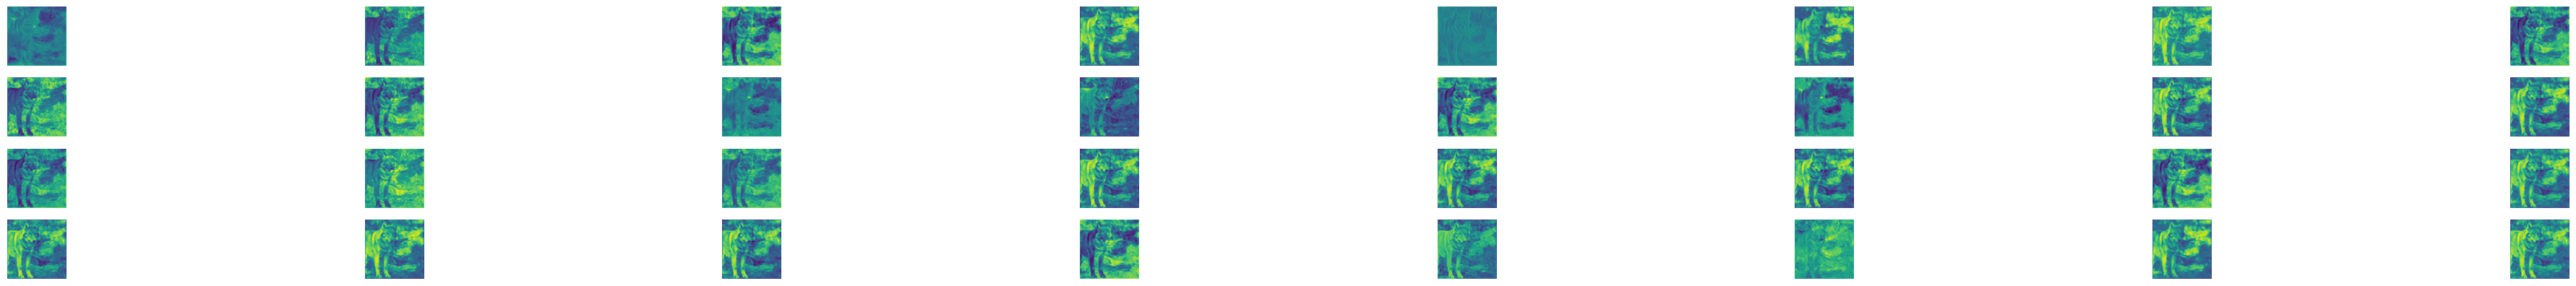

Layer  3


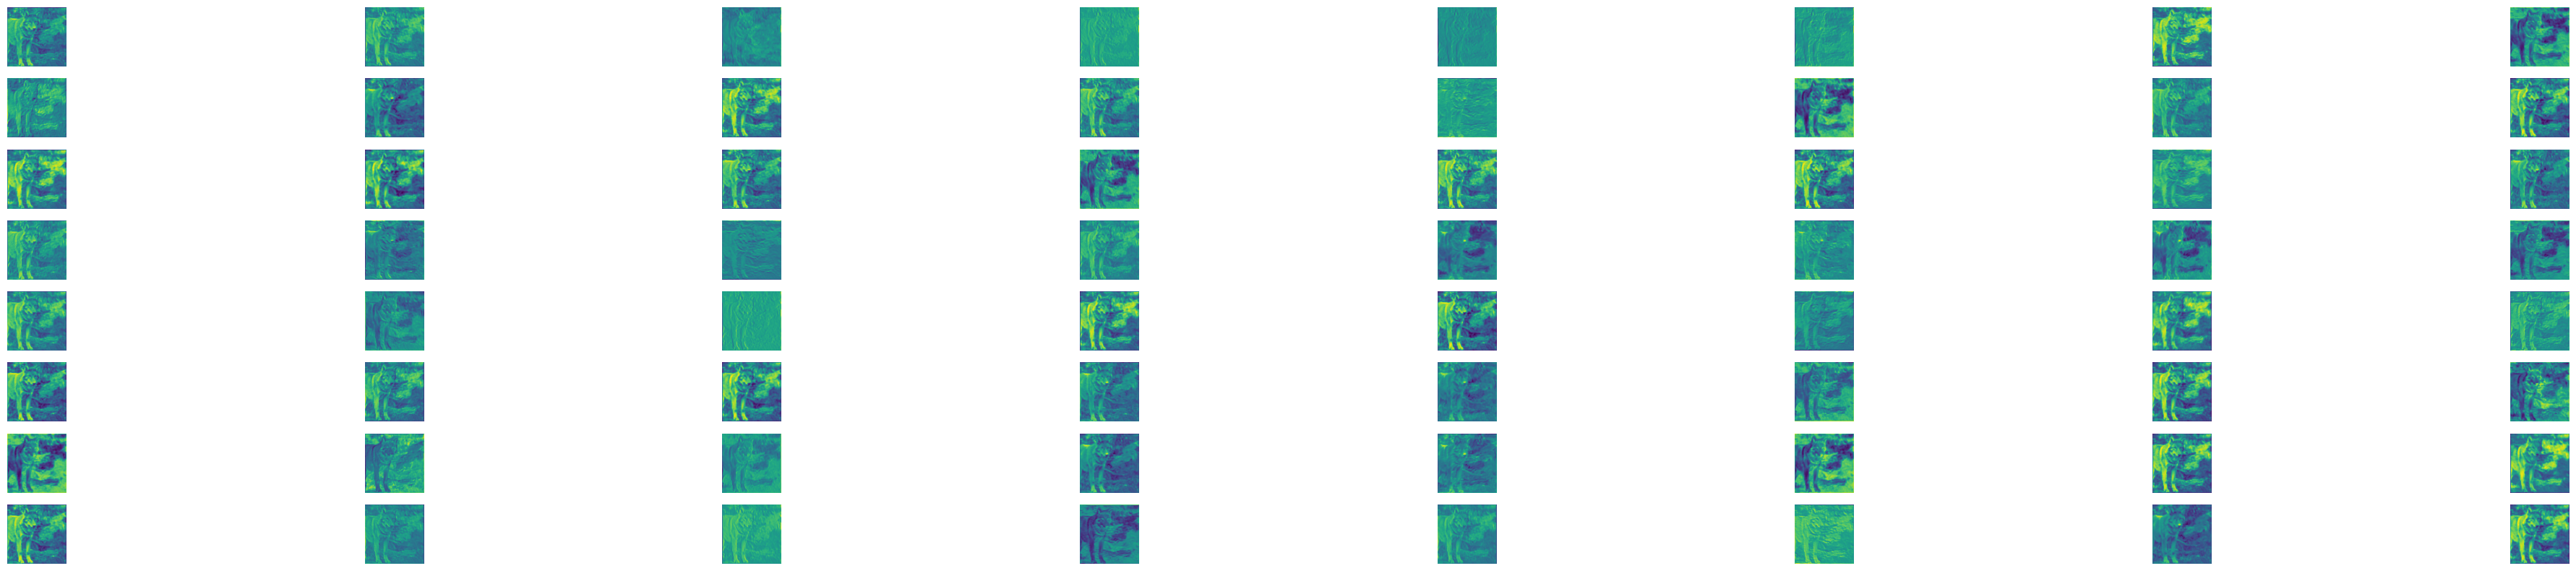

In [85]:
fivec_outputs, fivec_conv_layers = visualizing_feature_maps(fivec_custom_model, fivec_dataset.load_image(74), fivec_transforms, device)